In [1]:
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
import keras

fashion_mnist = tf.keras.datasets.fashion_mnist

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [2]:
!python --version

Python 3.10.12


In [3]:
# Завантаження датасету Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()


# Перевірка форми даних
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [4]:
# Зміна розмірності зображень на 32x32
train_images = tf.image.resize(train_images[..., tf.newaxis], [32, 32])
test_images = tf.image.resize(test_images[..., tf.newaxis], [32, 32])


In [5]:
# Збільшення кількості каналів у зображеннях з 1 до 3
train_images = tf.repeat(train_images, 3, axis=-1)
test_images = tf.repeat(test_images, 3, axis=-1)
print(train_images.shape)
print(test_images.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:

# Нормалізація піксельних значень до діапазону [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [7]:
# Створення об'єкта генератора даних з параметрами аугментації для навчальних даних
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Генератор даних для навчального набору
train_generator = train_datagen.flow(train_images, train_labels, batch_size=64)

# Генератор даних для валідаційного набору без аугментації
validation_datagen = ImageDataGenerator()

# Генератор даних для валідаційного набору
validation_generator = validation_datagen.flow(test_images, test_labels, batch_size=64)

In [8]:
# Завантаження VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [9]:

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [10]:

# Визначення моделі
model_vgg = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

In [11]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [12]:
# Компіляція моделі
model_vgg.compile(
    loss="sparse_categorical_crossentropy", # Зміна на sparse_categorical_crossentropy для багатокласової класифікації
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    optimizer='Adam',
    metrics=["accuracy"]
)


In [13]:

# Тренування моделі
history = model_vgg.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=100, # Зменшення кількості епох для швидшого тестування
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
15/15 [==============================] - 11s 237ms/step - loss: 1.8640 - accuracy: 0.4146 - val_loss: 1.3968 - val_accuracy: 0.6294
Epoch 2/100
15/15 [==============================] - 3s 174ms/step - loss: 1.2622 - accuracy: 0.5854 - val_loss: 1.0388 - val_accuracy: 0.6841
Epoch 3/100
15/15 [==============================] - 3s 192ms/step - loss: 1.0299 - accuracy: 0.6750 - val_loss: 0.9638 - val_accuracy: 0.6562
Epoch 4/100
15/15 [==============================] - 2s 121ms/step - loss: 0.9429 - accuracy: 0.6698 - val_loss: 0.8976 - val_accuracy: 0.6834
Epoch 5/100
15/15 [==============================] - 2s 113ms/step - loss: 0.8345 - accuracy: 0.7188 - val_loss: 0.8066 - val_accuracy: 0.7113
Epoch 6/100
15/15 [==============================] - 2s 168ms/step - loss: 0.7873 - accuracy: 0.7219 - val_loss: 0.7771 - val_accuracy: 0.7200
Epoch 7/100
15/15 [==============================] - 2s 137ms/step - loss: 0.7504 - accuracy: 0.7448 - val_loss: 0.7910 - val_accuracy: 0.713

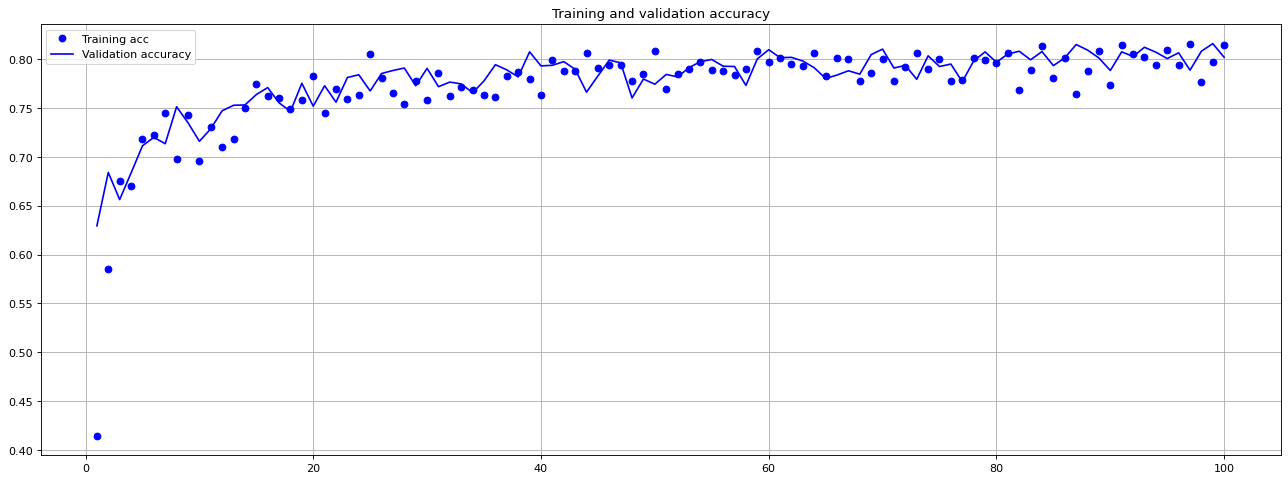

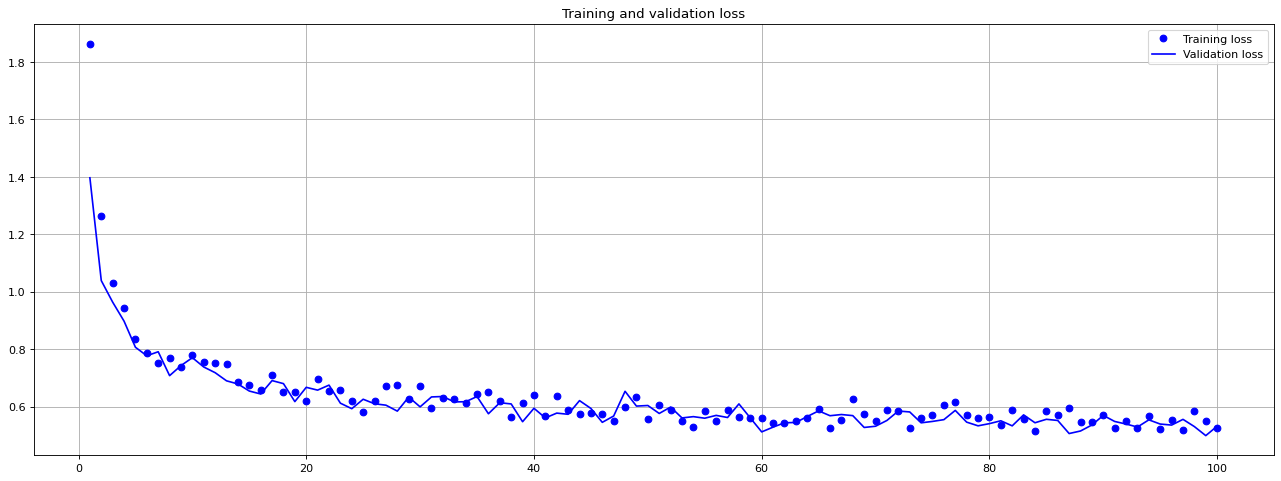

In [14]:

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [15]:

from sklearn.metrics import classification_report
import numpy as np

# Отримання передбачень для тестових даних
predictions = model_vgg.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Генерація classification report
report = classification_report(test_labels, predicted_classes)
print(report)

# Перевірка точності на тестових даних за допомогою генератора
test_loss, test_acc = model_vgg.evaluate(validation_generator, steps=len(test_images) // 64, verbose=2)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      1000
           1       0.98      0.95      0.96      1000
           2       0.69      0.69      0.69      1000
           3       0.88      0.67      0.76      1000
           4       0.62      0.74      0.67      1000
           5       0.97      0.90      0.93      1000
           6       0.52      0.54      0.53      1000
           7       0.90      0.93      0.92      1000
           8       0.97      0.90      0.93      1000
           9       0.91      0.96      0.94      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

156/156 - 2s - loss: 0.5275 - accuracy: 0.8059 - 2s/epoch - 10ms/step
Test accuracy: 0.8058894276618958


In [16]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Виведення номерів і назв класів
for idx, class_name in enumerate(class_names):
    print(f'Номер: {idx}, Назва: {class_name}')

Номер: 0, Назва: T-shirt/top
Номер: 1, Назва: Trouser
Номер: 2, Назва: Pullover
Номер: 3, Назва: Dress
Номер: 4, Назва: Coat
Номер: 5, Назва: Sandal
Номер: 6, Назва: Shirt
Номер: 7, Назва: Sneaker
Номер: 8, Назва: Bag
Номер: 9, Назва: Ankle boot


1/1 [==============================] - 1s 564ms/step


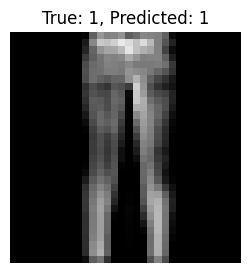

Class probabilities:
Class 0: 0.0415
Class 1: 0.6760
Class 2: 0.0141
Class 3: 0.2255
Class 4: 0.0204
Class 5: 0.0000
Class 6: 0.0222
Class 7: 0.0000
Class 8: 0.0003
Class 9: 0.0000
1/1 [==============================] - 0s 27ms/step


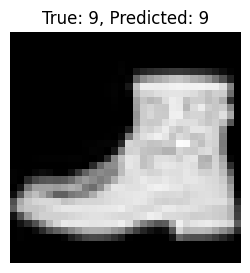

Class probabilities:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0003
Class 6: 0.0001
Class 7: 0.0001
Class 8: 0.0027
Class 9: 0.9966
1/1 [==============================] - 0s 28ms/step


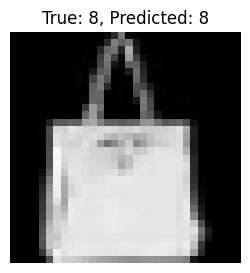

Class probabilities:
Class 0: 0.0018
Class 1: 0.0000
Class 2: 0.0058
Class 3: 0.0021
Class 4: 0.0029
Class 5: 0.0000
Class 6: 0.0022
Class 7: 0.0000
Class 8: 0.9850
Class 9: 0.0000
1/1 [==============================] - 0s 29ms/step


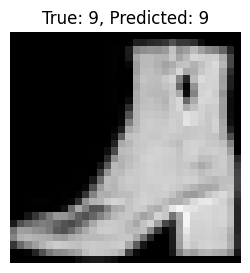

Class probabilities:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0003
Class 6: 0.0001
Class 7: 0.0020
Class 8: 0.0028
Class 9: 0.9948
1/1 [==============================] - 0s 35ms/step


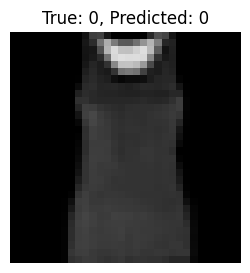

Class probabilities:
Class 0: 0.6428
Class 1: 0.0003
Class 2: 0.1438
Class 3: 0.0506
Class 4: 0.0145
Class 5: 0.0000
Class 6: 0.1467
Class 7: 0.0000
Class 8: 0.0012
Class 9: 0.0000


In [17]:
num_images = 5
indices = np.random.choice(len(test_images), num_images, replace=False)

for idx in indices:
    image = test_images[idx]
    true_label = test_labels[idx]

    # Make predictions
    y_pred_prob = model_vgg.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(y_pred_prob)

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

    print('Class probabilities:')
    for class_idx, prob in enumerate(y_pred_prob[0]):
        print(f'Class {class_idx}: {prob:.4f}')

In [18]:
model_vgg.save("fashion_mnist_model_VGG16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import pickle
# Збереження історії навчання
with open('fashion_mnist_model_VGG16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [21]:
optimizer_state = model_vgg.optimizer.variables()
with open('optimizer_state_model_vgg_VGG16.pkl', 'wb') as f:
    pickle.dump([v.numpy() for v in optimizer_state], f)

In [22]:

from tensorflow.keras.models import load_model

model_vgg16_loaded = load_model("fashion_mnist_model_VGG16.h5")
model_vgg16_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [23]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [24]:
!cp fashion_mnist_model_VGG16.h5 /content/drive/My\ Drive/Files/hw16/

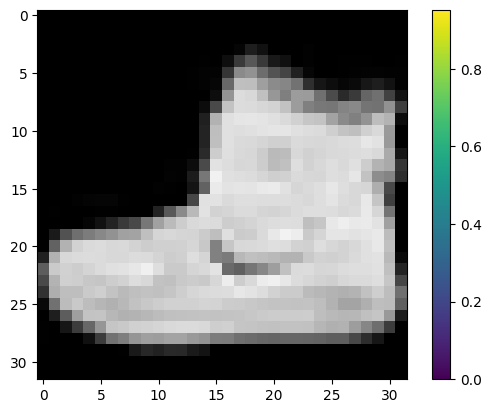

In [26]:
# Візуалізація першого зображення з тренувального датасету
plt.figure()
plt.imshow(train_images[0]) #, cmap='viridis'
plt.colorbar()
plt.grid(False)
plt.show()

In [27]:
# Завантаження датасету Fashion MNIST
(train_images2, train_labels2), (test_images2, test_labels2) = tf.keras.datasets.fashion_mnist.load_data()
# Зміна розмірності зображень на 32x32
train_images2 = tf.image.resize(train_images2[..., tf.newaxis], [32, 32])
test_images2 = tf.image.resize(test_images2[..., tf.newaxis], [32, 32])


In [31]:
# Збільшення кількості каналів у зображеннях з 1 до 3
train_images2 = tf.repeat(train_images2, 3, axis=-1)
test_images2 = tf.repeat(test_images2, 3, axis=-1)
print(train_images2.shape)
print(test_images2.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)


In [33]:
# Нормалізація піксельних значень до діапазону [0, 1]
train_images2 = train_images2 / 255.0
test_images2 = test_images2 / 255.0

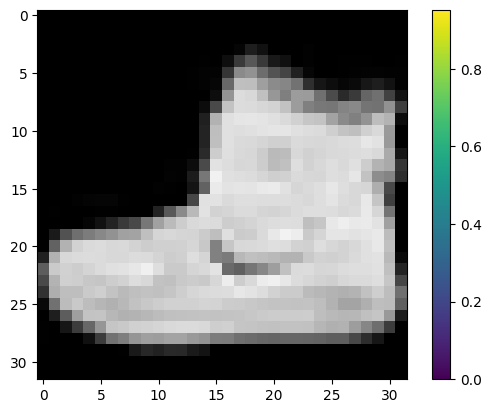

In [36]:
# Візуалізація першого зображення з тренувального датасету
plt.figure()
plt.imshow(train_images2[0], cmap='viridis') #
plt.colorbar()
plt.grid(False)
plt.show()

1/1 [==============================] - 0s 29ms/step


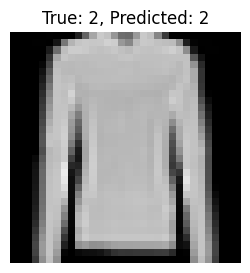

Class probabilities:
Class 0: 0.0011
Class 1: 0.0006
Class 2: 0.8783
Class 3: 0.0001
Class 4: 0.0334
Class 5: 0.0000
Class 6: 0.0864
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000
1/1 [==============================] - 0s 30ms/step


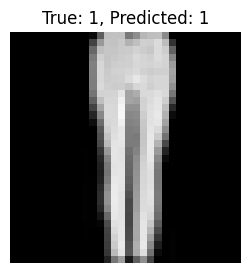

Class probabilities:
Class 0: 0.0001
Class 1: 0.9826
Class 2: 0.0000
Class 3: 0.0170
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0001
Class 7: 0.0000
Class 8: 0.0001
Class 9: 0.0000
1/1 [==============================] - 0s 27ms/step


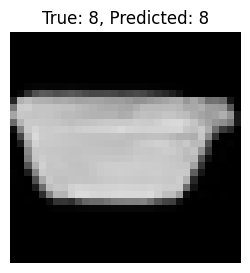

Class probabilities:
Class 0: 0.0070
Class 1: 0.0003
Class 2: 0.0009
Class 3: 0.0043
Class 4: 0.0003
Class 5: 0.0016
Class 6: 0.0094
Class 7: 0.0021
Class 8: 0.9650
Class 9: 0.0091
1/1 [==============================] - 0s 27ms/step


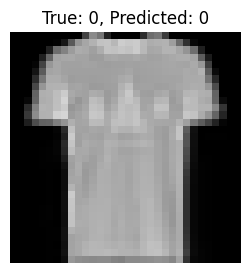

Class probabilities:
Class 0: 0.7687
Class 1: 0.0000
Class 2: 0.0140
Class 3: 0.0038
Class 4: 0.0189
Class 5: 0.0000
Class 6: 0.1945
Class 7: 0.0000
Class 8: 0.0001
Class 9: 0.0000
1/1 [==============================] - 0s 31ms/step


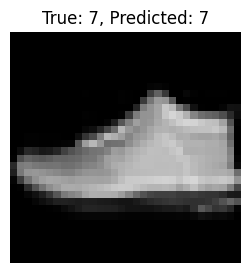

Class probabilities:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0015
Class 6: 0.0001
Class 7: 0.6288
Class 8: 0.0005
Class 9: 0.3690


In [35]:
num_images = 5
indices = np.random.choice(len(test_images2), num_images, replace=False)

for idx in indices:
    image = test_images2[idx]
    true_label = test_labels2[idx]

    # Make predictions
    y_pred_prob = model_vgg.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(y_pred_prob)

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

    print('Class probabilities:')
    for class_idx, prob in enumerate(y_pred_prob[0]):
        print(f'Class {class_idx}: {prob:.4f}')